In [ ]:
!pip install ultralytics

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pylab as pl
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/All Projects/Traffic Management/data.yaml' -d '/content/'

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/andrewmvd/helmet-detection/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: beckoliver
Your Kaggle Key: ··········


100%|██████████| 391M/391M [00:03<00:00, 118MB/s]


In [ ]:
od.download('https://www.kaggle.com/datasets/savanagrawal/helmet-detection-yolov3/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: beckoliver
Your Kaggle Key: ··········


100%|██████████| 218M/218M [00:02<00:00, 94.1MB/s]


In [ ]:
od.download('https://www.kaggle.com/datasets/savanagrawal/detect-person-on-motorbike-or-scooter/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: beckoliver
Your Kaggle Key: ··········


100%|██████████| 352M/352M [00:02<00:00, 133MB/s]


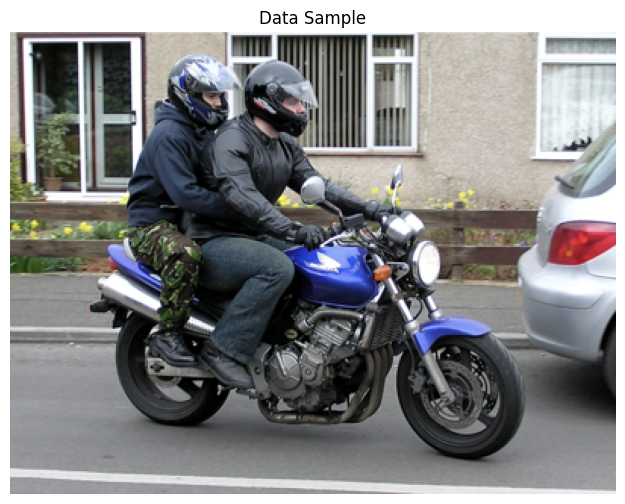

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img0 = "/content/helmet-detection/images/BikesHelmets100.png"

fig, ax = plt.subplots(figsize=(10, 6))
img = mpimg.imread(img0)
ax.imshow(img)
ax.set_title("Data Sample")
ax.axis('off')
plt.show()


In [ ]:
import os
import glob
import json
import xml.etree.ElementTree as XMLParser


def calculate_yolo_coordinates(xml_coords, img_width, img_height):
    x_avg = ((xml_coords[2] + xml_coords[0]) / 2) / img_width
    y_avg = ((xml_coords[3] + xml_coords[1]) / 2) / img_height
    obj_width = (xml_coords[2] - xml_coords[0]) / img_width
    obj_height = (xml_coords[3] - xml_coords[1]) / img_height
    return [x_avg, y_avg, obj_width, obj_height]


def retrieve_xml_coordinates(yolo_coords, img_width, img_height):
    half_width = (yolo_coords[2] * img_width) / 2
    half_height = (yolo_coords[3] * img_height) / 2
    lower_x = int((yolo_coords[0] * img_width) - half_width)
    lower_y = int((yolo_coords[1] * img_height) - half_height)
    upper_x = int((yolo_coords[0] * img_width) + half_width)
    upper_y = int((yolo_coords[1] * img_height) + half_height)
    return [lower_x, lower_y, upper_x, upper_y]


labels_list = []
input_path = "/content/helmet-detection/annotations"
result_path = "labels/"
img_path = "/content/helmet-detection/images"

if not os.path.exists(result_path):
    os.makedirs(result_path)

annotation_files = glob.glob(os.path.join(input_path, '*.xml'))

for file in annotation_files:
    base_name = os.path.basename(file)
    file_id = os.path.splitext(base_name)[0]

    if not os.path.isfile(os.path.join(img_path, f"{file_id}.png")):
        print(f"Image for {file_id} not found!")
        continue

    coordinates_data = []

    content = XMLParser.parse(file)
    main_element = content.getroot()
    img_width = int(main_element.find("size").find("width").text)
    img_height = int(main_element.find("size").find("height").text)

    for element in main_element.findall('object'):
        label = element.find("name").text
        if label not in labels_list:
            labels_list.append(label)
        label_idx = labels_list.index(label)
        coords = [int(coord.text) for coord in element.find("bndbox")]
        yolo_coords = calculate_yolo_coordinates(coords, img_width, img_height)
        coords_str = " ".join([str(coord) for coord in yolo_coords])
        coordinates_data.append(f"{label_idx} {coords_str}")

    if coordinates_data:
        with open(os.path.join(result_path, f"{file_id}.txt"), "w", encoding="utf-8") as output_file:
            output_file.write("\n".join(coordinates_data))

with open('labels_reference.txt', 'w', encoding='utf8') as label_file:
    label_file.write(json.dumps(labels_list))



In [ ]:
import cv2

# Paths to weights, configurations and labels
weights_path = 'detect-person-on-motorbike-or-scooter/yolov3-obj_final.weights'
config_path = 'detect-person-on-motorbike-or-scooter/yolov3_pb.cfg'
labels_path = 'detect-person-on-motorbike-or-scooter/coco.names'

# Thresholds for detection
min_probability = 0.5
iou_threshold = 0.3

# Load the neural network
yolo_net = cv2.dnn.readNetFromDarknet(config_path, weights_path)

# Get the names of layers
all_layer_names = yolo_net.getLayerNames()
output_layer_names = [all_layer_names[i - 1] for i in yolo_net.getUnconnectedOutLayers()]

# Read and split labels
object_labels = open(labels_path).read().strip().split('\n')
print(object_labels)


['person_bike']


In [ ]:
# Paths for the network files
helmet_weights_path = 'helmet-detection-yolov3/yolov3-helmet.weights'
helmet_config_path = 'helmet-detection-yolov3/yolov3-helmet.cfg'
helmet_labels_path = 'helmet-detection-yolov3/helmet.names'

# Load the YOLO network for helmet detection
helmet_net = cv2.dnn.readNetFromDarknet(helmet_config_path, helmet_weights_path)

# Fetch the names of all layers and output layers
all_helmet_layers = helmet_net.getLayerNames()
output_helmet_layers = [all_helmet_layers[index - 1] for index in helmet_net.getUnconnectedOutLayers()]

# Extract and print labels for the network
helmet_labels = open(helmet_labels_path).read().strip().split('\n')
print(helmet_labels)


['Helmet']


In [ ]:
import cv2
import numpy as np

def generate_boxes_from_detections(detections, img_width, img_height, prob_min):
    b_boxes = []
    confs = []
    class_nums = []

    for detection in detections:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        if confidence > prob_min:
            box = detection[0:4] * np.array([img_width, img_height, img_width, img_height])
            x_center, y_center, width, height = box.astype('int')
            x_min = int(x_center - (width / 2))
            y_min = int(y_center - (height / 2))

            b_boxes.append([x_min, y_min, int(width), int(height)])
            confs.append(float(confidence))
            class_nums.append(class_id)

    return b_boxes, confs, class_nums


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

def create_directory_structure(base_path, subdirs):
    """Creates necessary directory structure."""
    for subdir in subdirs:
        os.makedirs(os.path.join(base_path, subdir))

def move_files(files, source_dir, dest_dir, extension=".png"):
    """Moves files from source to destination directory."""
    for filename in files:
        image_name = f"{filename[:-4]}{extension}"
        shutil.copy(os.path.join(source_dir, image_name), os.path.join(dest_dir, "images", image_name))
        shutil.copy(os.path.join(LABELS_DIRECTORY, filename), os.path.join(dest_dir, "labels", filename))

# Constants
IMAGES_DIRECTORY = "/content/helmet-detection/images"
LABELS_DIRECTORY = "/content/labels"

# Read label files
label_files = os.listdir(LABELS_DIRECTORY)

# Split datasets
train_labels, test_valid_labels = train_test_split(label_files, test_size=0.15, shuffle=True)
valid_labels, test_labels = train_test_split(test_valid_labels, test_size=0.2)

print(f"Train set: {len(train_labels)}\nValidation set: {len(valid_labels)}\nTest set: {len(test_labels)}")

# Create necessary directories
subdirectories = ["images", "labels"]
create_directory_structure("train", subdirectories)
create_directory_structure("valid", subdirectories)
create_directory_structure("test", subdirectories)

# Move files to their respective directories
move_files(train_labels, IMAGES_DIRECTORY, "train")
move_files(valid_labels, IMAGES_DIRECTORY, "valid")
move_files(test_labels, IMAGES_DIRECTORY, "test")

print("Data split and rearrangement completed!")


Train set: 646
Validation set: 92
Test set: 23
Data split and rearrangement completed!
